In [208]:
import numpy as np
import math
import itertools as it
import colorsys

# --- Bokeh Imports ---
from bokeh.plotting import figure, show
from bokeh.models import (
    ColumnDataSource, 
    HoverTool, 
    CategoricalColorMapper, 
    LinearColorMapper,
    ColorBar,
    CustomJS,
    RadioGroup,
    Range1d,
    Div,
    Plot,
    Rect,
    Text
)
from bokeh.layouts import column, row
from bokeh.io import output_notebook, show


class Layout:
    """
    Analyzes shared memory access patterns for various tensor layout permutations.

    This class models the process of mapping a high-level, N-dimensional
    tensor access (defined by shape `S` and strides `D`) to the underlying
    physical shared memory (smem) addresses.

    It computes all permutations of the tensor strides, calculates the
    resulting smem word addresses for every element, and analyzes the
    resulting bank conflicts for each layout, both with and without
    a swizzle operation.

    Args:
        m (int): The dimensionality of the tensor (e.g., 2 for a 2D tensor).
        S (np.ndarray): The shape of the tensor (1D array of size `m`).
        D (np.ndarray): The base strides of the tensor (1D array of size `m`).
        b_bits (int): The number of bits to use in the swizzle operation.
        m_base (int): The base bit offset for the swizzle operation.
        s_shift (int): The bit-shift distance for the swizzle operation.
        warp_size (int): The number of threads in a warp (e.g., 32).
        smem_word_width (int): The width of a shared memory word in bits (e.g., 32 or 64).
        element_vector_size (int): The number of scalar elements per vector (e.g., 1, 2, 4).
        element_type_width (int): The width of a single scalar element in bits (e.g., 16 for fp16).
        address_atom_width (int): The smallest addressable unit in bits (e.g., 4 for 4-bit atoms).
        n_banks (int): The number of shared memory banks (e.g., 32).

    Attributes:
        m (int): Tensor dimensionality.
        S (np.ndarray): Tensor shape.
        D (np.ndarray): Tensor strides.
        N_perms (int): Number of permutations (m!).
        perms (np.ndarray): Array of shape (N_perms, m) holding all permutations.
        D_permuted (np.ndarray): Array of shape (N_perms, m) holding all permuted stride vectors.
        N_elems (int): Total number of elements in the tensor (prod(S)).
        flat_domain (np.ndarray): 1D array from 0 to N_elems-1.
        shape_strides (np.ndarray): Column-major strides for the shape S.
        flat_to_nd_indices (np.ndarray): Map of shape (1, N_elems, m) to convert flat index to N-D index.
        vector_addresses (np.ndarray): Array of shape (N_perms, N_elems) holding the logical
                                          vector address for each element in each layout.
        smem_address_map (np.ndarray): Array of shape (N_perms, N_elems, max_smem_addrs)
                                          mapping each element to the set of smem words it hits.
        swizzle_mask (int): The bitmask covering all bits involved in the swizzle.
        swizzled_vector_addresses (np.ndarray): `vector_addresses` after applying the swizzle.
        swizzled_smem_address_map (np.ndarray): `smem_address_map` for swizzled addresses.
        layout_bank_hits (np.ndarray): Array of shape (N_perms, N_warps, n_banks)
                                          storing bank hit counts for each non-swizzled layout.
        swizzled_bank_hits (np.ndarray): Bank hit counts for swizzled layouts.
    """
    def __init__(self, m:int, S:np.ndarray, D:np.ndarray, b_bits:int, m_base:int, 
                 s_shift:int, warp_size:int, smem_word_width:int, 
                 element_vector_size:int, element_type_width:int, address_atom_width:int, n_banks:int):
        
        # --- 1. Parameter Validation ---
        assert m <= 4, "Dimensionality m > 4 not supported (too many permutations)"
        assert S.shape == (m,)
        assert D.shape == (m,)
        assert b_bits >= 0
        assert m_base >= 0
        assert abs(s_shift) >= b_bits, "Swizzle shift must be at least b_bits"
        assert np.prod(S).item() <= 1024, "Total elements must be <= 64"
        assert np.prod(D).item() <= 1024, "Total strides product must be <= 64"
        assert (np.prod(S).item() % warp_size == 0), "Total elements must be a multiple of warp_size"

        self.m = m
        self.S = S
        self.D = D
        self.b_bits = b_bits
        self.m_base = m_base
        self.s_shift = s_shift

        # --- 2. Permutation Generation ---
        self.N_perms = self._factorial(m)
        self.perms = self._generate_perms(m)
        # Apply permutations to the strides D, not shape S
        self.D_permuted = self._apply_perms(self.D, self.perms) 

        # --- 3. N-D Index to Linear Address Mapping ---
        self.N_elems = np.prod(S).item()
        self.flat_domain = np.arange(self.N_elems)
        
        # Calculate column-major strides for the shape S
        shape_strides = np.ones((m,), dtype=int)
        for i in reversed(range(m - 1)):
            shape_strides[i] = S[i + 1] * shape_strides[i + 1]
        self.shape_strides = shape_strides
        
        # Use broadcasting to convert flat_domain into N-D indices
        # Shape: (1, N_elems, m)
        self.flat_to_nd_indices = (self.flat_domain.reshape(1, self.N_elems, 1) // self.shape_strides.reshape(1, 1, self.m)) \
                                  % (self.S.reshape(1, 1, self.m))
        
        # Calculate logical vector address for each element under each layout permutation
        # This is a dot product: sum(D_permuted * nd_index)
        # Shape: (N_perms, N_elems)
        self.vector_addresses = np.sum(self.D_permuted.reshape(self.N_perms, 1, self.m) * self.flat_to_nd_indices, axis=-1)
        
        # --- 4. Logical Address to Physical smem Word Mapping ---
        self.smem_address_map = self._layout_to_smem_addr(
            self.vector_addresses, 
            element_vector_size, element_type_width, 
            smem_word_width, address_atom_width
        )

        # --- 5. Apply Swizzle ---
        self.swizzle_mask, self.swizzled_vector_addresses = self._apply_swizzle(
            self.vector_addresses, b_bits, m_base, s_shift
        )
        
        self.swizzled_smem_address_map = self._layout_to_smem_addr(
            self.swizzled_vector_addresses, 
            element_vector_size, element_type_width, 
            smem_word_width, address_atom_width
        )

        # --- 6. Bank Conflict Analysis ---
        self.layout_bank_hits = self._get_bank_hits(
            self.smem_address_map, warp_size, n_banks, self.N_elems, self.N_perms
        )
        
        self.swizzled_bank_hits = self._get_bank_hits(
            self.swizzled_smem_address_map, warp_size, n_banks, self.N_elems, self.N_perms
        )

    def _factorial(self, n: int) -> int:
        """Calculates factorial n!."""
        return math.factorial(n)

    def _generate_perms(self, n: int) -> np.ndarray:
        """Generates all permutations for a list of n indices."""
        return np.array(list(it.permutations(range(n))), dtype=int)

    def _apply_perms(self, X: np.ndarray, perms: np.ndarray) -> np.ndarray:
        """
        Applies all permutations to a vector X.
        
        Args:
            X (np.ndarray): 1D array of size (m,).
            perms (np.ndarray): 2D array of permutations of shape (N_perms, m).
            
        Returns:
            np.ndarray: A 2D array of shape (N_perms, m) where each row
                        is a permuted version of X.
        """
        return X[perms]

    def _layout_to_smem_addr(self, layout_addresses: np.ndarray, 
                             vector_size: int, element_type_width: int, 
                             smem_word_width: int, address_atom_width: int) -> np.ndarray:
        """
        Maps a 2D array of logical vector addresses to their physical smem word sets.

        Args:
            layout_addresses (np.ndarray): 2D array (N_perms, N_elems) of logical addresses.
            ... (other args): Passed to helper.

        Returns:
            np.ndarray: 3D array (N_perms, N_elems, max_smem_addrs) mapping
                        each element to its set of smem words. Padded with -1.
        """
        n_perms, n_elems = layout_addresses.shape
        S, ew, sw, aw = vector_size, element_type_width, smem_word_width, address_atom_width

        # --- Calculate theoretical max smem words per vector (for padding) ---
        N_bits_per_vector = ew * S
        # Worst-case span for N bits across 'aw'-bit atoms
        max_n_addr_atoms = ((N_bits_per_vector - 2) // aw) + 2 if N_bits_per_vector > 1 else 1
        # Atoms per smem word
        atoms_per_smem_word = sw // aw
        # Worst-case span for 'max_n_addr_atoms' across 'atoms_per_smem_word' words
        max_n_smem_addrs = ((max_n_addr_atoms - 2) // atoms_per_smem_word) + 2 if max_n_addr_atoms > 1 else 1
        
        # Pre-fill the output map with -1 (padding)
        layout_to_smem_addr_map = -np.ones((n_perms, n_elems, max_n_smem_addrs), dtype=int)
        
        # Loop is necessary because np.unique returns ragged (variable-size) arrays
        for i in range(n_perms):
            for j in range(n_elems):
                vec_addr = layout_addresses[i, j]
                smem_addr_set = self._abs_vec_addr_to_smem_addr_set(
                    vec_addr, S, ew, sw, aw
                )
                
                n_actual = smem_addr_set.size
                if n_actual > max_n_smem_addrs:
                    # This should not happen if the bound is correct, but good to check
                    raise ValueError(f"Address {vec_addr} hit {n_actual} words, but bound was {max_n_smem_addrs}")
                    
                layout_to_smem_addr_map[i, j, 0:n_actual] = smem_addr_set

        return layout_to_smem_addr_map

    def _abs_vec_addr_to_smem_addr_set(self, vec_addr: int, vector_size: int, 
                                       element_type_width: int, smem_word_width: int, 
                                       address_atom_width: int) -> np.ndarray:
        """
        Calculates the unique set of smem words hit by a single vector access.

        Args:
            vec_addr (int): The logical vector address.
            ... (other args): Type and hardware geometry.

        Returns:
            np.ndarray: A 1D array of the unique smem word addresses hit.
        """
        v, S, ew, sw, aw = vec_addr, vector_size, element_type_width, smem_word_width, address_atom_width

        # 1. Get scalar element indices
        Q = np.arange(S)
        # 2. Get absolute scalar element addresses
        abs_scalar_addr = (v * S) + Q
        # 3. Get bit indices (column vector)
        EW = np.arange(ew).reshape(ew, 1)
        # 4. Broadcast to get all bit addresses
        bit_addrs = EW + (ew * abs_scalar_addr)
        # 5. Convert bit addresses to atom addresses
        atom_addrs = bit_addrs // aw
        # 6. Convert atom addresses to smem word addresses
        smem_addrs = atom_addrs // (sw // aw)

        # 7. Find the unique set of smem words hit
        smem_addr_set_actual = np.unique(smem_addrs)
        return smem_addr_set_actual

    def _apply_swizzle(self, X: np.ndarray, b_bits: int, m_base: int, s_shift: int) -> (int, np.ndarray):
        """
        Applies a bitwise XOR swizzle to the layout addresses.

        Args:
            X (np.ndarray): 2D array of layout addresses (N_perms, N_elems).
            ... (other args): Swizzle parameters.

        Returns:
            tuple: (swizzle_mask, swizzled_X)
                swizzle_mask (int): The mask covering all bits involved.
                swizzled_X (np.ndarray): The swizzled address array.
        """
        # Create masks
        base_mask = (1 << b_bits) - 1
        
        # Source/Destination shifts based on s_shift direction
        src_shift = m_base + max(0, s_shift)
        dst_shift = m_base - min(0, s_shift)
        
        src_mask = base_mask << src_shift
        dst_mask = base_mask << dst_shift
        swizzle_mask = src_mask | dst_mask

        # Isolate the bits to move
        bits_to_move = X & src_mask
        
        # Apply XOR swizzle
        if s_shift > 0:
            # Shift bits from src down to dst
            swizzled_X = X ^ (bits_to_move >> abs(s_shift))
        else:
            # Shift bits from src up to dst
            swizzled_X = X ^ (bits_to_move << abs(s_shift))

        return swizzle_mask, swizzled_X

    def _get_bank_hits(self, layout_to_addr: np.ndarray, warp_size: int, 
                       n_banks: int, n_elems: int, n_perms: int) -> np.ndarray:
        """
        Calculates the bank hit statistics for all layouts.

        Args:
            layout_to_addr (np.ndarray): 3D map of (perm, elem, smem_addrs).
            ... (other args): Geometry parameters.

        Returns:
            np.ndarray: 3D array (N_perms, N_warps, n_banks) containing the
                        total number of accesses to each bank per warp.
                        The max of this array is the conflict degree.
        """
        n_warps = n_elems // warp_size
        n_addrs_per_thread = layout_to_addr.shape[-1]

        # Reshape to (perm, warp, thread, addrs)
        addr_map_warped = layout_to_addr.reshape(n_perms, n_warps, warp_size, n_addrs_per_thread)

        # Accumulator for hit counts
        bank_hits = np.zeros((n_perms, n_warps, n_banks), dtype=int)

        # We must loop over perms and warps, but can vectorize the thread/address dimensions
        for p in range(n_perms):
            for w in range(n_warps):
                # Get all addresses for this warp: (warp_size, n_addrs)
                warp_addrs = addr_map_warped[p, w]

                # Filter out all padding (-1)
                valid_addrs = warp_addrs[warp_addrs != -1]

                if valid_addrs.size == 0:
                    continue # No addresses for this warp

                # Calculate banks for all valid addresses
                banks = valid_addrs % n_banks

                # Count occurrences of each bank
                # This gives the total number of accesses to each bank
                unique_banks, counts = np.unique(banks, return_counts=True)

                # Store these counts in the accumulator
                bank_hits[p, w, unique_banks] = counts

        return bank_hits

In [209]:
m = 2 
S = np.array([128,4])
D = np.array([4,1])
b_bits = 3 
m_base = 1
s_shift = 4
warp_size = 32
smem_word_width = 32
element_vector_size = 4 
element_type_width = 32
address_atom_width = 8 
n_banks = 32

L = Layout(m, S,D, b_bits, m_base, s_shift, warp_size,
           smem_word_width, element_vector_size, element_type_width,
           address_atom_width, n_banks)


In [210]:
print(L.swizzle_mask)
L.swizzled_bank_hits

238


array([[[4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        ...,
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4]],

       [[4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        ...,
        [4, 4, 4, ..., 4, 4, 4],
        [5, 5, 5, ..., 3, 3, 3],
        [5, 5, 5, ..., 3, 3, 3]]], shape=(2, 16, 32))

In [211]:
class LayoutVisualizer(Layout):
    """
    Interactive visualizer for Layout bank conflicts and address maps
    using Bokeh.
    
    Inherits from Layout to run all calculations, then provides a .display()
    method to launch an interactive dashboard in a new browser tab.
    """
    
    def __init__(self, *args, **kwargs):
        # Run the full Layout calculation
        super().__init__(*args, **kwargs)
        
        # Store key geometry for plotting
        self.n_banks = kwargs.get('n_banks', 32)
        self.warp_size = kwargs.get('warp_size', 32)
        self.n_warps = self.N_elems // self.warp_size
        
        # --- Visualization Parameters ---
        self.GRID_WIDTH = 64  # How many addresses wide to make the 2D tile
        self.DEFAULT_COLOR = "#f0f0f0"
        
        # --- Generate Data for Bokeh ---
        print("Generating thread colors...")
        self._generate_thread_colors()
        
        print("Preparing data sources for all permutations...")
        self._prepare_all_data_sources()
        print("Data preparation complete.")

    def _rgb_to_hex(self, r, g, b):
        """Converts RGB (0-1) to hex string."""
        return '#%02x%02x%02x' % (int(r*255), int(g*255), int(b*255))

    def _generate_thread_colors(self):
        """
        Generates a unique color for each thread (element).
        Hue = Warp ID
        Saturation/Lightness = Lane ID
        """
        self.thread_colors_hex = []
        hues = np.linspace(0, 1, self.n_warps, endpoint=False)
        
        # Create a 4x8 grid for Saturation and Value (Lightness)
        sats = np.linspace(0.6, 1.0, 4)
        vals = np.linspace(0.5, 1.0, 8)
        
        for w in range(self.n_warps):
            for l in range(self.warp_size):
                h = hues[w]
                # Map lane ID to the 4x8 grid
                s = sats[l % 4]
                v = vals[l // 4] 
                
                r, g, b = colorsys.hsv_to_rgb(h, s, v)
                self.thread_colors_hex.append(self._rgb_to_hex(r, g, b))

    def _prepare_all_data_sources(self):
        """Pre-computes and stores all data sources for all permutations."""
        
        # Find the global max address across all permutations to set the grid size
        self.max_global_addr = max(
            np.max(self.smem_address_map), 
            np.max(self.swizzled_smem_address_map)
        )
        
        self.N_BOXES = self.max_global_addr + 1
        self.N_ROWS = (self.N_BOXES + self.GRID_WIDTH - 1) // self.GRID_WIDTH
        
        # --- Create the base grid (same for all plots) ---
        self.base_grid_data = {
            'x': [], 'y': [], 'address': [], 'bank': [], 'addr_str': []
        }
        for i in range(self.N_BOXES):
            self.base_grid_data['x'].append(i % self.GRID_WIDTH)
            # Y-axis is inverted so 0 is at the top-left
            self.base_grid_data['y'].append(self.N_ROWS - 1 - (i // self.GRID_WIDTH))
            self.base_grid_data['address'].append(i)
            self.base_grid_data['bank'].append(i % self.n_banks)
            self.base_grid_data['addr_str'].append(str(i))
            
        # Now, prepare the permutation-specific data
        self.all_data = {}
        for p in range(self.N_perms):
            self.all_data[p] = self._prepare_data_for_perm(p)
            
    def _prepare_data_for_perm(self, p: int):
        """
        Processes the raw data for a single permutation into
        Bokeh-ready ColumnDataSources.
        """
        
        # --- 1. Address Map Data ---
        # Start with default colors/info
        color_map = [self.DEFAULT_COLOR] * self.N_BOXES
        thread_info_map = ["N/A"] * self.N_BOXES
        
        swizzled_color_map = [self.DEFAULT_COLOR] * self.N_BOXES
        swizzled_thread_info_map = ["N/A"] * self.N_BOXES
        
        for e in range(self.N_elems): # e = element/thread ID
            warp_id = e // self.warp_size
            lane_id = e % self.warp_size
            thread_color = self.thread_colors_hex[e]
            info = f"Thread {e} (W{warp_id}, L{lane_id})"
            
            # Process non-swizzled map
            for addr in self.smem_address_map[p, e]:
                if addr == -1: continue
                color_map[addr] = thread_color
                thread_info_map[addr] = info

            # Process swizzled map
            for addr in self.swizzled_smem_address_map[p, e]:
                if addr == -1: continue
                swizzled_color_map[addr] = thread_color
                swizzled_thread_info_map[addr] = info
        
        # Combine base grid with permutation data
        map_data = self.base_grid_data.copy()
        map_data['color'] = color_map
        map_data['thread_info'] = thread_info_map
        
        swizzled_map_data = self.base_grid_data.copy()
        swizzled_map_data['color'] = swizzled_color_map
        swizzled_map_data['thread_info'] = swizzled_thread_info_map

        # --- 2. Bank Hit Data (Heatmap) ---
        hits_data = {'warp': [], 'bank': [], 'hits': []}
        swizzled_hits_data = {'warp': [], 'bank': [], 'hits': []}
        
        hits_slice = self.layout_bank_hits[p]
        swizzled_hits_slice = self.swizzled_bank_hits[p]
        
        for w in range(self.n_warps):
            for b in range(self.n_banks):
                hits_data['warp'].append(str(w)) # Use strings for categorical range
                hits_data['bank'].append(str(b))
                hits_data['hits'].append(hits_slice[w, b])
                
                swizzled_hits_data['warp'].append(str(w))
                swizzled_hits_data['bank'].append(str(b))
                swizzled_hits_data['hits'].append(swizzled_hits_slice[w, b])
        
        return (
            ColumnDataSource(map_data), 
            ColumnDataSource(swizzled_map_data),
            ColumnDataSource(hits_data),
            ColumnDataSource(swizzled_hits_data),
            np.max(hits_slice), # max conflict
            np.max(swizzled_hits_slice) # swizzled max conflict
        )
            
    def _create_color_legend(self):
        """Creates a Bokeh plot to serve as a 2D color legend for threads."""
        
        data = {'x': [], 'y': [], 'color': []}
        for w in range(self.n_warps):
            for l in range(self.warp_size):
                data['x'].append(l)
                data['y'].append(w)
                data['color'].append(self.thread_colors_hex[w * self.warp_size + l])
        
        source = ColumnDataSource(data)
        
        p = figure(
            width=900,
            height=250,
            title="Thread Color Legend (Y-axis: Warp ID, X-axis: Lane ID)",
            x_range=Range1d(-0.5, self.warp_size - 0.5),
            y_range=Range1d(-0.5, self.n_warps - 0.5),
            tools="hover",
            tooltips=[("Warp", "@y"), ("Lane", "@x")]
        )
        p.rect(x='x', y='y', width=1, height=1, color='color', source=source)
        p.xaxis.axis_label = "Lane ID"
        p.yaxis.axis_label = "Warp ID"
        p.xaxis.ticker = list(range(self.warp_size))
        p.yaxis.ticker = list(range(self.n_warps))
        return p

    def display(self):
        """
        Renders the interactive Bokeh visualization dashboard.
        
        Call this in a Jupyter notebook cell (or it will open in a new tab).
        """
        
        # --- 1. Create Plots ---
        TOOLS = "pan,wheel_zoom,box_zoom,reset,save"
        
        addr_map_hover = HoverTool(tooltips=[
            ("Address", "@address"),
            ("Bank", "@bank"),
            ("Access", "@thread_info"),
        ])
        
        # Create shared ranges for the 2D grid plots
        x_range = Range1d(-0.5, self.GRID_WIDTH - 0.5)
        y_range = Range1d(-0.5, self.N_ROWS - 0.5)

        # Plot 1: Non-Swizzled Address Map
        p_map = figure(
            height=600, 
            width=900, 
            title="Non-Swizzled Address Map", 
            tools=[TOOLS, addr_map_hover],
            x_range=x_range,
            y_range=y_range,
            match_aspect=True # Keep boxes square
        )
        p_map.rect(x='x', y='y', width=1, height=1, color='color', source=self.all_data[0][0])
        p_map.text(x='x', y='y', text='addr_str', source=self.all_data[0][0],
                   text_font_size='7px', text_align='center', text_baseline='middle')
        p_map.xaxis.axis_label = f"Address (Tiled in rows of {self.GRID_WIDTH})"
        p_map.yaxis.visible = False

        # Plot 2: Swizzled Address Map
        p_map_swizzled = figure(
            height=600, 
            width=900, 
            title="Swizzled Address Map", 
            tools=[TOOLS, addr_map_hover],
            x_range=x_range, # Link X/Y axes
            y_range=y_range,
            match_aspect=True
        )
        p_map_swizzled.rect(x='x', y='y', width=1, height=1, color='color', source=self.all_data[0][1])
        p_map_swizzled.text(x='x', y='y', text='addr_str', source=self.all_data[0][1],
                            text_font_size='7px', text_align='center', text_baseline='middle')
        p_map_swizzled.xaxis.axis_label = f"Address (Tiled in rows of {self.GRID_WIDTH})"
        p_map_swizzled.yaxis.visible = False
        
        # --- Bank Hit Plots ---
        hits_hover = HoverTool(tooltips=[
            ("Warp", "@warp"),
            ("Bank", "@bank"),
            ("Hits", "@hits"),
        ])
        
        bank_labels = [str(i) for i in range(self.n_banks)]
        warp_labels = [str(i) for i in range(self.n_warps)]

        # Use Div for titles
        plot_width = 900
        title_hits = Div(
            text=f"<h3>Non-Swizzled Bank Hits (Max Conflict: {self.all_data[0][4]}-way)</h3>",
            width=plot_width
        )
        title_hits_swizzled = Div(
            text=f"<h3>Swizzled Bank Hits (Max Conflict: {self.all_data[0][5]}-way)</h3>",
            width=plot_width
        )

        # Plot 3: Non-Swizzled Bank Hits
        max_c = max(1, self.all_data[0][4])
        color_mapper = LinearColorMapper(palette="Reds9", low=0, high=max_c)
        p_hits = figure(
            height=400, 
            width=plot_width, 
            x_range=bank_labels, 
            y_range=warp_labels,
            tools=[hits_hover, "save"],
            x_axis_location="above",
            title="Non-Swizzled Bank Hits" # Static title
        )
        p_hits.rect(x='bank', y='warp', width=1, height=1, source=self.all_data[0][2], 
                    fill_color={'field': 'hits', 'transform': color_mapper}, line_color=None)
        p_hits.xaxis.axis_label = "Bank ID"
        p_hits.yaxis.axis_label = "Warp ID"
        color_bar = ColorBar(color_mapper=color_mapper, label_standoff=12, location=(0,0))
        p_hits.add_layout(color_bar, 'right')

        # Plot 4: Swizzled Bank Hits
        max_c_swizzled = max(1, self.all_data[0][5])
        color_mapper_swizzled = LinearColorMapper(palette="Reds9", low=0, high=max_c_swizzled)
        p_hits_swizzled = figure(
            height=400, 
            width=plot_width, 
            x_range=p_hits.x_range, 
            y_range=p_hits.y_range,
            tools=[hits_hover, "save"],
            x_axis_location="above",
            title="Swizzled Bank Hits" # Static title
        )
        p_hits_swizzled.rect(x='bank', y='warp', width=1, height=1, source=self.all_data[0][3],
                            fill_color={'field': 'hits', 'transform': color_mapper_swizzled}, line_color=None)
        p_hits_swizzled.xaxis.axis_label = "Bank ID"
        p_hits_swizzled.yaxis.axis_label = "Warp ID"
        color_bar_swizzled = ColorBar(color_mapper=color_mapper_swizzled, label_standoff=12, location=(0,0))
        p_hits_swizzled.add_layout(color_bar_swizzled, 'right')
        
        # --- 2. Create Controls & Callbacks ---
        
        radio_group = RadioGroup(
            labels=[f"Permutation {i}" for i in range(self.N_perms)], 
            active=0
        )
        
        callback_args = dict(
            all_data=self.all_data,
            map_source=self.all_data[0][0],
            map_swizzled_source=self.all_data[0][1],
            hits_source=self.all_data[0][2],
            hits_swizzled_source=self.all_data[0][3],
            color_mapper=color_mapper,
            color_mapper_swizzled=color_mapper_swizzled,
            title_hits=title_hits,
            title_hits_swizzled=title_hits_swizzled
        )
        
        callback_code = """
            const perm_index = cb_obj.active;
            const new_data = all_data[perm_index];
            
            // Update data sources
            map_source.data = new_data[0].data;
            map_swizzled_source.data = new_data[1].data;
            hits_source.data = new_data[2].data;
            hits_swizzled_source.data = new_data[3].data;
            
            // Update color mappers
            const max_hits = new_data[4];
            const max_hits_swizzled = new_data[5];
            
            color_mapper.high = Math.max(1, max_hits);
            color_mapper_swizzled.high = Math.max(1, max_hits_swizzled);
            
            // Update titles
            title_hits.text = `<h3>Non-Swizzled Bank Hits (Max Conflict: ${max_hits}-way)</h3>`;
            title_hits_swizzled.text = `<h3>Swizzled Bank Hits (Max Conflict: ${max_hits_swizzled}-way)</h3>`;
        """
        
        radio_group.js_on_change('active', CustomJS(args=callback_args, code=callback_code))
        
        # --- 3. Layout Dashboard ---
        legend = self._create_color_legend()
        
        layout = column(
            radio_group,
            legend,
            row(p_map, p_map_swizzled),
            row(
                column(title_hits, p_hits),
                column(title_hits_swizzled, p_hits_swizzled)
            )
        )
        
        # show() will open in a new browser tab or display in the notebook
        show(layout)



In [212]:
m = 2 
S = np.array([32,32])
D = np.array([1,32])
b_bits = 5
m_base = 1
s_shift = 5
warp_size = 32
smem_word_width = 32
element_vector_size = 1
element_type_width = 32
address_atom_width = 8 
n_banks = 32

LT = LayoutVisualizer(m, S,D, b_bits, m_base, s_shift, warp_size,
           smem_word_width, element_vector_size, element_type_width,
           address_atom_width, n_banks)


Generating thread colors...
Preparing data sources for all permutations...
Data preparation complete.


In [213]:
LT.display()

In [214]:
m = 2 
S = np.array([32,32])
D = np.array([32,1])
b_bits = 5
m_base = 1
s_shift = 5
warp_size = 32
smem_word_width = 32
element_vector_size = 1
element_type_width = 32
address_atom_width = 8 
n_banks = 32

L = LayoutVisualizer(m, S,D, b_bits, m_base, s_shift, warp_size,
           smem_word_width, element_vector_size, element_type_width,
           address_atom_width, n_banks)


Generating thread colors...
Preparing data sources for all permutations...
Data preparation complete.


In [215]:
L.display()

In [216]:
class LayoutVisualizer(Layout):
    """
    Interactive visualizer for Layout bank conflicts and address maps
    using Bokeh.
    
    Inherits from Layout to run all calculations, then provides a .display()
    method to launch an interactive dashboard in a new browser tab.
    
    ACCEPTS A NEW KWARG:
    - thread_colors (list): A list of N_elems colors (hex strings or RGB tuples)
                            to use for coloring. If not provided,
                            colors are generated automatically.
    """
    
    def __init__(self, *args, **kwargs):
        # --- NEW: Pop custom colors from kwargs ---
        # We pop it so the super() call doesn't receive an 
        # unknown 'thread_colors' argument.
        custom_colors = kwargs.pop('thread_colors', None)
        
        # Run the full Layout calculation
        super().__init__(*args, **kwargs)
        
        # Store key geometry for plotting
        self.n_banks = kwargs.get('n_banks', 32)
        self.warp_size = kwargs.get('warp_size', 32)
        self.n_warps = self.N_elems // self.warp_size
        
        # --- Visualization Parameters ---
        self.GRID_WIDTH = 64  # How many addresses wide to make the 2D tile
        self.DEFAULT_COLOR = "#f0f0f0"
        
        # --- Generate Data for Bokeh ---
        print("Generating thread colors...")
        
        # --- NEW: Use custom colors if provided ---
        if custom_colors is not None:
            print("Using provided custom thread colors.")
            self._set_custom_thread_colors(custom_colors)
        else:
            print("No custom colors provided, generating new colors.")
            self._generate_thread_colors()
        
        print("Preparing data sources for all permutations...")
        self._prepare_all_data_sources()
        print("Data preparation complete.")

    def _rgb_to_hex(self, r, g, b):
        """Converts RGB (0-1) to hex string."""
        return '#%02x%02x%02x' % (int(r*255), int(g*255), int(b*255))

    # --- NEW METHOD ---
    def _set_custom_thread_colors(self, colors):
        """Validates and sets a user-provided color list."""
        if len(colors) != self.N_elems:
            raise ValueError(
                f"The provided 'thread_colors' list has {len(colors)} elements, "
                f"but this layout requires {self.N_elems} colors."
            )
        
        if not colors:
            self.thread_colors_hex = []
            return
            
        first_color = colors[0]
        
        if isinstance(first_color, str):
            # Assume colors are already hex strings
            print("Interpreting colors as hex strings.")
            self.thread_colors_hex = list(colors)
        elif (isinstance(first_color, (tuple, list)) and 
              len(first_color) == 3 and 
              isinstance(first_color[0], (int, float))):
            
            # Check if (0-255) or (0-1) scale
            if first_color[0] > 1:
                print("Interpreting colors as (0-255) RGB tuples.")
                # Normalize from (0-255) to (0-1)
                self.thread_colors_hex = [
                    self._rgb_to_hex(r/255.0, g/255.0, b/255.0) 
                    for r, g, b in colors
                ]
            else:
                print("Interpreting colors as (0-1) RGB tuples.")
                # Assume (0-1)
                self.thread_colors_hex = [
                    self._rgb_to_hex(r, g, b) for r, g, b in colors
                ]
        else:
            raise ValueError(
                "Unknown color format in 'thread_colors'. "
                "Please provide a list of hex strings or (R,G,B) tuples."
            )

    def _generate_thread_colors(self):
        """
        Generates a unique color for each thread (element).
        Hue = Warp ID
        Saturation/Lightness = Lane ID
        
        (This is now a fallback if no colors are provided)
        """
        self.thread_colors_hex = []
        hues = np.linspace(0, 1, self.n_warps, endpoint=False)
        
        # Create a 4x8 grid for Saturation and Value (Lightness)
        sats = np.linspace(0.6, 1.0, 4)
        vals = np.linspace(0.5, 1.0, 8)
        
        for w in range(self.n_warps):
            for l in range(self.warp_size):
                h = hues[w]
                # Map lane ID to the 4x8 grid
                s = sats[l % 4]
                v = vals[l // 4] 
                
                r, g, b = colorsys.hsv_to_rgb(h, s, v)
                self.thread_colors_hex.append(self._rgb_to_hex(r, g, b))

    def _prepare_all_data_sources(self):
        """Pre-computes and stores all data sources for all permutations."""
        
        # Find the global max address across all permutations to set the grid size
        self.max_global_addr = max(
            np.max(self.smem_address_map), 
            np.max(self.swizzled_smem_address_map)
        )
        
        self.N_BOXES = self.max_global_addr + 1
        self.N_ROWS = (self.N_BOXES + self.GRID_WIDTH - 1) // self.GRID_WIDTH
        
        # --- Create the base grid (same for all plots) ---
        self.base_grid_data = {
            'x': [], 'y': [], 'address': [], 'bank': [], 'addr_str': []
        }
        for i in range(self.N_BOXES):
            self.base_grid_data['x'].append(i % self.GRID_WIDTH)
            # Y-axis is inverted so 0 is at the top-left
            self.base_grid_data['y'].append(self.N_ROWS - 1 - (i // self.GRID_WIDTH))
            self.base_grid_data['address'].append(i)
            self.base_grid_data['bank'].append(i % self.n_banks)
            self.base_grid_data['addr_str'].append(str(i))
            
        # Now, prepare the permutation-specific data
        self.all_data = {}
        for p in range(self.N_perms):
            self.all_data[p] = self._prepare_data_for_perm(p)
            
    def _prepare_data_for_perm(self, p: int):
        """
        Processes the raw data for a single permutation into
        Bokeh-ready ColumnDataSources.
        """
        
        # --- 1. Address Map Data ---
        # Start with default colors/info
        color_map = [self.DEFAULT_COLOR] * self.N_BOXES
        thread_info_map = ["N/A"] * self.N_BOXES
        
        swizzled_color_map = [self.DEFAULT_COLOR] * self.N_BOXES
        swizzled_thread_info_map = ["N/A"] * self.N_BOXES
        
        for e in range(self.N_elems): # e = element/thread ID
            warp_id = e // self.warp_size
            lane_id = e % self.warp_size
            
            # This line now uses either the generated or custom colors
            thread_color = self.thread_colors_hex[e] 
            
            info = f"Thread {e} (W{warp_id}, L{lane_id})"
            
            # Process non-swizzled map
            for addr in self.smem_address_map[p, e]:
                if addr == -1: continue
                if 0 <= addr < self.N_BOXES: # Bounds check
                    color_map[addr] = thread_color
                    thread_info_map[addr] = info

            # Process swizzled map
            for addr in self.swizzled_smem_address_map[p, e]:
                if addr == -1: continue
                if 0 <= addr < self.N_BOXES: # Bounds check
                    swizzled_color_map[addr] = thread_color
                    swizzled_thread_info_map[addr] = info
        
        # Combine base grid with permutation data
        map_data = self.base_grid_data.copy()
        map_data['color'] = color_map
        map_data['thread_info'] = thread_info_map
        
        swizzled_map_data = self.base_grid_data.copy()
        swizzled_map_data['color'] = swizzled_color_map
        swizzled_map_data['thread_info'] = swizzled_thread_info_map

        # --- 2. Bank Hit Data (Heatmap) ---
        hits_data = {'warp': [], 'bank': [], 'hits': []}
        swizzled_hits_data = {'warp': [], 'bank': [], 'hits': []}
        
        hits_slice = self.layout_bank_hits[p]
        swizzled_hits_slice = self.swizzled_bank_hits[p]
        
        for w in range(self.n_warps):
            for b in range(self.n_banks):
                hits_data['warp'].append(str(w)) # Use strings for categorical range
                hits_data['bank'].append(str(b))
                hits_data['hits'].append(hits_slice[w, b])
                
                swizzled_hits_data['warp'].append(str(w))
                swizzled_hits_data['bank'].append(str(b))
                swizzled_hits_data['hits'].append(swizzled_hits_slice[w, b])
        
        return (
            ColumnDataSource(map_data), 
            ColumnDataSource(swizzled_map_data),
            ColumnDataSource(hits_data),
            ColumnDataSource(swizzled_hits_data),
            np.max(hits_slice), # max conflict
            np.max(swizzled_hits_slice) # swizzled max conflict
        )
            
    def _create_color_legend(self):
        """Creates a Bokeh plot to serve as a 2D color legend for threads."""
        
        data = {'x': [], 'y': [], 'color': [], 'info': []}
        for w in range(self.n_warps):
            for l in range(self.warp_size):
                e = w * self.warp_size + l
                data['x'].append(l)
                data['y'].append(w)
                data['color'].append(self.thread_colors_hex[e])
                data['info'].append(f"Thread {e} (W{w}, L{l})")

        source = ColumnDataSource(data)
        
        p = figure(
            width=900,
            height=250 + 10 * (self.n_warps - 8), # Give a bit more room for more warps
            title="Thread Color Legend (Y-axis: Warp ID, X-axis: Lane ID)",
            x_range=Range1d(-0.5, self.warp_size - 0.5),
            y_range=Range1d(-0.5, self.n_warps - 0.5),
            tools="hover",
            tooltips=[("Info", "@info"), ("Color", "@color")]
        )
        p.rect(x='x', y='y', width=1, height=1, color='color', source=source)
        p.xaxis.axis_label = "Lane ID"
        p.yaxis.axis_label = "Warp ID"
        p.xaxis.ticker = list(range(self.warp_size))
        p.yaxis.ticker = list(range(self.n_warps))
        return p

    def display(self):
        """
        Renders the interactive Bokeh visualization dashboard.
        
        Call this in a Jupyter notebook cell (or it will open in a new tab).
        """
        
        # --- 1. Create Plots ---
        TOOLS = "pan,wheel_zoom,box_zoom,reset,save"
        
        addr_map_hover = HoverTool(tooltips=[
            ("Address", "@address"),
            ("Bank", "@bank"),
            ("Access", "@thread_info"),
        ])
        
        # Create shared ranges for the 2D grid plots
        x_range = Range1d(-0.5, self.GRID_WIDTH - 0.5)
        y_range = Range1d(-0.5, self.N_ROWS - 0.5)

        # Plot 1: Non-Swizzled Address Map
        p_map = figure(
            height=600, 
            width=900, 
            title="Non-Swizzled Address Map", 
            tools=[TOOLS, addr_map_hover],
            x_range=x_range,
            y_range=y_range,
            match_aspect=True # Keep boxes square
        )
        p_map.rect(x='x', y='y', width=1, height=1, color='color', source=self.all_data[0][0])
        p_map.text(x='x', y='y', text='addr_str', source=self.all_data[0][0],
                   text_font_size='7px', text_align='center', text_baseline='middle')
        p_map.xaxis.axis_label = f"Address (Tiled in rows of {self.GRID_WIDTH})"
        p_map.yaxis.visible = False

        # Plot 2: Swizzled Address Map
        p_map_swizzled = figure(
            height=600, 
            width=900, 
            title="Swizzled Address Map", 
            tools=[TOOLS, addr_map_hover],
            x_range=x_range, # Link X/Y axes
            y_range=y_range,
            match_aspect=True
        )
        p_map_swizzled.rect(x='x', y='y', width=1, height=1, color='color', source=self.all_data[0][1])
        p_map_swizzled.text(x='x', y='y', text='addr_str', source=self.all_data[0][1],
                            text_font_size='7px', text_align='center', text_baseline='middle')
        p_map_swizzled.xaxis.axis_label = f"Address (Tiled in rows of {self.GRID_WIDTH})"
        p_map_swizzled.yaxis.visible = False
        
        # --- Bank Hit Plots ---
        hits_hover = HoverTool(tooltips=[
            ("Warp", "@warp"),
            ("Bank", "@bank"),
            ("Hits", "@hits"),
        ])
        
        bank_labels = [str(i) for i in range(self.n_banks)]
        warp_labels = [str(i) for i in range(self.n_warps)]

        # Use Div for titles
        plot_width = 900
        title_hits = Div(
            text=f"<h3>Non-Swizzled Bank Hits (Max Conflict: {self.all_data[0][4]}-way)</h3>",
            width=plot_width
        )
        title_hits_swizzled = Div(
            text=f"<h3>Swizzled Bank Hits (Max Conflict: {self.all_data[0][5]}-way)</h3>",
            width=plot_width
        )

        # Plot 3: Non-Swizzled Bank Hits
        max_c = max(1, self.all_data[0][4])
        color_mapper = LinearColorMapper(palette="Reds9", low=0, high=max_c)
        p_hits = figure(
            height=max(300, 25 * self.n_warps), # Scale height with warp count
            width=plot_width, 
            x_range=bank_labels, 
            y_range=list(reversed(warp_labels)), # Invert y-axis to match legend
            tools=[hits_hover, "save"],
            x_axis_location="above",
        )
        p_hits.rect(x='bank', y='warp', width=1, height=1, source=self.all_data[0][2], 
                    fill_color={'field': 'hits', 'transform': color_mapper}, line_color=None)
        p_hits.xaxis.axis_label = "Bank ID"
        p_hits.yaxis.axis_label = "Warp ID"
        color_bar = ColorBar(color_mapper=color_mapper, label_standoff=12, location=(0,0))
        p_hits.add_layout(color_bar, 'right')

        # Plot 4: Swizzled Bank Hits
        max_c_swizzled = max(1, self.all_data[0][5])
        color_mapper_swizzled = LinearColorMapper(palette="Reds9", low=0, high=max_c_swizzled)
        p_hits_swizzled = figure(
            height=p_hits.height, # Match height
            width=plot_width, 
            x_range=p_hits.x_range, 
            y_range=p_hits.y_range,
            tools=[hits_hover, "save"],
            x_axis_location="above",
        )
        p_hits_swizzled.rect(x='bank', y='warp', width=1, height=1, source=self.all_data[0][3],
                            fill_color={'field': 'hits', 'transform': color_mapper_swizzled}, line_color=None)
        p_hits_swizzled.xaxis.axis_label = "Bank ID"
        p_hits_swizzled.yaxis.axis_label = "Warp ID"
        color_bar_swizzled = ColorBar(color_mapper=color_mapper_swizzled, label_standoff=12, location=(0,0))
        p_hits_swizzled.add_layout(color_bar_swizzled, 'right')
        
        # --- 2. Create Controls & Callbacks ---
        
        radio_group = RadioGroup(
            labels=[f"Permutation {i}" for i in range(self.N_perms)], 
            active=0
        )
        
        callback_args = dict(
            all_data=self.all_data,
            map_source=self.all_data[0][0],
            map_swizzled_source=self.all_data[0][1],
            hits_source=self.all_data[0][2],
            hits_swizzled_source=self.all_data[0][3],
            color_mapper=color_mapper,
            color_mapper_swizzled=color_mapper_swizzled,
            title_hits=title_hits,
            title_hits_swizzled=title_hits_swizzled
        )
        
        callback_code = """
            const perm_index = cb_obj.active;
            const new_data = all_data[perm_index];
            
            // Update data sources
            map_source.data = new_data[0].data;
            map_swizzled_source.data = new_data[1].data;
            hits_source.data = new_data[2].data;
            hits_swizzled_source.data = new_data[3].data;
            
            // Update color mappers
            const max_hits = new_data[4];
            const max_hits_swizzled = new_data[5];
            
            color_mapper.high = Math.max(1, max_hits);
            color_mapper_swizzled.high = Math.max(1, max_hits_swizzled);
            
            // Update titles
            title_hits.text = `<h3>Non-Swizzled Bank Hits (Max Conflict: ${max_hits}-way)</h3>`;
            title_hits_swizzled.text = `<h3>Swizzled Bank Hits (Max Conflict: ${max_hits_swizzled}-way)</h3>`;
            
            // Emit changes
            map_source.change.emit();
            map_swizzled_source.change.emit();
            hits_source.change.emit();
            hits_swizzled_source.change.emit();
        """
        
        radio_group.js_on_change('active', CustomJS(args=callback_args, code=callback_code))
        
        # --- 3. Layout Dashboard ---
        legend = self._create_color_legend()
        
        layout = column(
            radio_group,
            legend,
            row(p_map, p_map_swizzled),
            row(
                column(title_hits, p_hits),
                column(title_hits_swizzled, p_hits_swizzled)
            ),
            sizing_mode="scale_width"
        )
        
        # show() will open in a new browser tab or display in the notebook
        show(layout)

In [217]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors



In [218]:
def display_hsv_grid(h_array, s_array, v_array, x_label="X-Axis", y_label="Y-Axis", title="HSV Color Grid"):
    """
    Takes three 2D NumPy arrays (H, S, V) and displays them as a color image.
    
    Args:
        h_array (np.ndarray): 2D array for Hue (values expected in [0, 1])
        s_array (np.ndarray): 2D array for Saturation (values expected in [0, 1])
        v_array (np.ndarray): 2D array for Value (values expected in [0, 1])
        x_label (str): Label for the plot's x-axis
        y_label (str): Label for the plot's y-axis
        title (str): Title for the plot
    """
    
    # --- 1. Validate Input ---
    if not (h_array.shape == s_array.shape == v_array.shape and h_array.ndim == 2):
        raise ValueError("Input arrays must all be 2D and have the same shape.")
    
    print(f"Creating HSV image of shape {h_array.shape}...")
    
    # --- 2. Create the 3D HSV Array ---
    # We stack the 2D arrays along a new, final axis (axis=-1)
    # This creates a 3D array of shape (height, width, 3)
    # where the last dimension holds [H, S, V] for each pixel.
    hsv_image = np.stack([h_array, s_array, v_array], axis=-1)
    
    # --- 3. Convert HSV to RGB ---
    # matplotlib.colors.hsv_to_rgb is vectorized and works directly
    # on NumPy arrays. It expects H, S, V to be in the [0, 1] range.
    print("Converting from HSV to RGB...")
    rgb_image = matplotlib.colors.hsv_to_rgb(hsv_image)
    
    # --- 4. Display the Image ---
    print("Displaying plot...")
    fig, ax = plt.subplots(figsize=(8, 7))
    
    # We use imshow to display the 3D RGB array as an image.
    # origin='lower' puts the (0,0) index at the bottom-left.
    # extent=[0, 1, 0, 1] scales the axes to match the H/S input range.
    ax.imshow(rgb_image, origin='lower', extent=[0, 1, 0, 1], aspect='auto')
    
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    plt.show()
    
def display_hsv_cartesian_product(h_values, s_values, v_values, title="HSV Cartesian Product"):
    """
    Takes three 1D NumPy arrays (H, S, V) and displays a 2D grid
    of their Cartesian product.
    
    Args:
        h_values (np.ndarray): 1D array of Hue values (in [0, 1])
        s_values (np.ndarray): 1D array of Saturation values (in [0, 1])
        v_values (np.ndarray): 1D array of Value values (in [0, 1])
        title (str): Title for the plot
    """
    
    # --- 1. Validate Input ---
    if not (h_values.ndim == 1 and s_values.ndim == 1 and v_values.ndim == 1):
        raise ValueError("Input arrays must all be 1D.")
        
    N_h = len(h_values)
    N_s = len(s_values)
    N_v = len(v_values)
    
    print(f"Creating Cartesian product grid from:")
    print(f"  {N_h} Hue values")
    print(f"  {N_s} Saturation values")
    print(f"  {N_v} Value values")
    print(f"Total colors: {N_h * N_s * N_v}")

    # --- 2. Create the 3D HSV Block ---
    # Use meshgrid to create 3D arrays representing all combinations
    # indexing='ij' makes H vary on axis 0, S on axis 1, V on axis 2
    H, S, V = np.meshgrid(h_values, s_values, v_values, indexing='ij')
    
    # H, S, and V are now 3D arrays of shape (N_h, N_s, N_v)
    
    # Stack them into a 4D array: (N_h, N_s, N_v, 3)
    hsv_block = np.stack([H, S, V], axis=-1)
    
    # --- 3. Reshape to 2D for Display ---
    # We'll make a 2D image where:
    # - Y-axis (rows) = Hues (N_h tall)
    # - X-axis (cols) = S*V combinations (N_s * N_v wide)
    hsv_image_2d = hsv_block.reshape(N_h, N_s * N_v, 3)
    
    # --- 4. Convert to RGB ---
    print("Converting from HSV to RGB...")
    rgb_image = matplotlib.colors.hsv_to_rgb(hsv_image_2d)
    
    # --- 5. Display the Image ---
    print("Displaying plot...")
    # Set figsize: aim for wider than tall
    fig_width = 10
    fig_height = max(5, fig_width * (N_h / (N_s * N_v)) * 0.5)
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    
    ax.imshow(rgb_image, origin='lower', aspect='auto', 
              extent=[0, N_s * N_v, 0, N_h])
    
    ax.set_title(title)
    
    # Set Y-axis ticks to show Hue values
    ax.set_ylabel("Hue")
    ax.set_yticks(np.arange(N_h) + 0.5)
    ax.set_yticklabels([f"{h:.2f}" for h in h_values])
    
    # Set X-axis ticks to show S/V groups
    ax.set_xlabel("Saturation / Value Combinations")
    ax.set_xticks(np.arange(N_s) * N_v + (N_v / 2))
    ax.set_xticklabels([f"S={s:.2f}" for s in s_values])
    
    # Add minor ticks for V values
    ax.set_xticks(np.arange(N_s * N_v) + 0.5, minor=True)
    ax.tick_params(axis='x', which='minor', length=0) # Hide minor tick lines
    
    # Add grid lines to separate S-groups
    ax.grid(axis='x', color='white', linestyle='-', linewidth=2)
    ax.grid(axis='x', which='minor', color='gray', linestyle=':', linewidth=0.5)
    
    plt.tight_layout()
    plt.show()




In [219]:
class LayoutVisualizer(Layout):
    """
    Interactive visualizer for Layout bank conflicts and address maps
    using Bokeh.
    
    Inherits from Layout to run all calculations, then provides a .display()
    method to launch an interactive dashboard in a new browser tab.
    
    ACCEPTS NEW KWARGS:
    - thread_colors (list): A list of N_elems colors (hex strings or RGB tuples)
                            to use for coloring. If not provided,
                            colors are generated automatically.
    - grid_width (int):     The number of addresses to show per row in the
                            address map plots. Defaults to 64.
    """
    
    def __init__(self, *args, **kwargs):
        # --- NEW: Pop custom kwargs ---
        # We pop them so the super() call doesn't receive
        # unknown arguments.
        custom_colors = kwargs.pop('thread_colors', None)
        grid_width = kwargs.pop('grid_width', 64)
        
        # Run the full Layout calculation
        super().__init__(*args, **kwargs)
        
        # Store key geometry for plotting
        self.n_banks = kwargs.get('n_banks', 32)
        self.warp_size = kwargs.get('warp_size', 32)
        self.n_warps = self.N_elems // self.warp_size
        
        # --- Visualization Parameters ---
        self.GRID_WIDTH = grid_width  # Use the provided grid_width
        self.DEFAULT_COLOR = "#f0f0f0"
        
        # --- Generate Data for Bokeh ---
        print("Generating thread colors...")
        
        # --- Use custom colors if provided ---
        if custom_colors is not None:
            print("Using provided custom thread colors.")
            self._set_custom_thread_colors(custom_colors)
        else:
            print("No custom colors provided, generating new colors.")
            self._generate_thread_colors()
        
        print("Preparing data sources for all permutations...")
        self._prepare_all_data_sources()
        print("Data preparation complete.")

    def _rgb_to_hex(self, r, g, b):
        """Converts RGB (0-1) to hex string."""
        return '#%02x%02x%02x' % (int(r*255), int(g*255), int(b*255))

    def _set_custom_thread_colors(self, colors):
        """Validates and sets a user-provided color list."""
        if len(colors) != self.N_elems:
            raise ValueError(
                f"The provided 'thread_colors' list has {len(colors)} elements, "
                f"but this layout requires {self.N_elems} colors."
            )
        
        if not colors:
            self.thread_colors_hex = []
            return
            
        first_color = colors[0]
        
        if isinstance(first_color, str):
            # Assume colors are already hex strings
            print("Interpreting colors as hex strings.")
            self.thread_colors_hex = list(colors)
        elif (isinstance(first_color, (tuple, list)) and 
              len(first_color) == 3 and 
              isinstance(first_color[0], (int, float))):
            
            # Check if (0-255) or (0-1) scale
            if first_color[0] > 1:
                print("Interpreting colors as (0-255) RGB tuples.")
                # Normalize from (0-255) to (0-1)
                self.thread_colors_hex = [
                    self._rgb_to_hex(r/255.0, g/255.0, b/255.0) 
                    for r, g, b in colors
                ]
            else:
                print("Interpreting colors as (0-1) RGB tuples.")
                # Assume (0-1)
                self.thread_colors_hex = [
                    self._rgb_to_hex(r, g, b) for r, g, b in colors
                ]
        else:
            raise ValueError(
                "Unknown color format in 'thread_colors'. "
                "Please provide a list of hex strings or (R,G,B) tuples."
            )

    def _generate_thread_colors(self):
        """
        Generates a unique color for each thread (element).
        Hue = Warp ID
        Saturation/Lightness = Lane ID
        
        (This is now a fallback if no colors are provided)
        """
        self.thread_colors_hex = []
        hues = np.linspace(0, 1, self.n_warps, endpoint=False)
        
        # Create a 4x8 grid for Saturation and Value (Lightness)
        sats = np.linspace(0.6, 1.0, 4)
        vals = np.linspace(0.5, 1.0, 8)
        
        for w in range(self.n_warps):
            for l in range(self.warp_size):
                h = hues[w]
                # Map lane ID to the 4x8 grid
                s = sats[l % 4]
                v = vals[l // 4] 
                
                r, g, b = colorsys.hsv_to_rgb(h, s, v)
                self.thread_colors_hex.append(self._rgb_to_hex(r, g, b))

    def _prepare_all_data_sources(self):
        """Pre-computes and stores all data sources for all permutations."""
        
        # Find the global max address across all permutations to set the grid size
        self.max_global_addr = max(
            np.max(self.smem_address_map), 
            np.max(self.swizzled_smem_address_map)
        )
        
        self.N_BOXES = self.max_global_addr + 1
        # This calculation now uses the user-defined self.GRID_WIDTH
        self.N_ROWS = (self.N_BOXES + self.GRID_WIDTH - 1) // self.GRID_WIDTH
        
        # --- Create the base grid (same for all plots) ---
        self.base_grid_data = {
            'x': [], 'y': [], 'address': [], 'bank': [], 'addr_str': []
        }
        for i in range(self.N_BOXES):
            # These calculations also use self.GRID_WIDTH
            self.base_grid_data['x'].append(i % self.GRID_WIDTH)
            # Y-axis is inverted so 0 is at the top-left
            self.base_grid_data['y'].append(self.N_ROWS - 1 - (i // self.GRID_WIDTH))
            self.base_grid_data['address'].append(i)
            self.base_grid_data['bank'].append(i % self.n_banks)
            self.base_grid_data['addr_str'].append(str(i))
            
        # Now, prepare the permutation-specific data
        self.all_data = {}
        for p in range(self.N_perms):
            self.all_data[p] = self._prepare_data_for_perm(p)
            
    def _prepare_data_for_perm(self, p: int):
        """
        Processes the raw data for a single permutation into
        Bokeh-ready ColumnDataSources.
        """
        
        # --- 1. Address Map Data ---
        # Start with default colors/info
        color_map = [self.DEFAULT_COLOR] * self.N_BOXES
        thread_info_map = ["N/A"] * self.N_BOXES
        
        swizzled_color_map = [self.DEFAULT_COLOR] * self.N_BOXES
        swizzled_thread_info_map = ["N/A"] * self.N_BOXES
        
        for e in range(self.N_elems): # e = element/thread ID
            warp_id = e // self.warp_size
            lane_id = e % self.warp_size
            
            # This line now uses either the generated or custom colors
            thread_color = self.thread_colors_hex[e] 
            
            info = f"Thread {e} (W{warp_id}, L{lane_id})"
            
            # Process non-swizzled map
            for addr in self.smem_address_map[p, e]:
                if addr == -1: continue
                if 0 <= addr < self.N_BOXES: # Bounds check
                    color_map[addr] = thread_color
                    thread_info_map[addr] = info

            # Process swizzled map
            for addr in self.swizzled_smem_address_map[p, e]:
                if addr == -1: continue
                if 0 <= addr < self.N_BOXES: # Bounds check
                    swizzled_color_map[addr] = thread_color
                    swizzled_thread_info_map[addr] = info
        
        # Combine base grid with permutation data
        map_data = self.base_grid_data.copy()
        map_data['color'] = color_map
        map_data['thread_info'] = thread_info_map
        
        swizzled_map_data = self.base_grid_data.copy()
        swizzled_map_data['color'] = swizzled_color_map
        swizzled_map_data['thread_info'] = swizzled_thread_info_map

        # --- 2. Bank Hit Data (Heatmap) ---
        hits_data = {'warp': [], 'bank': [], 'hits': []}
        swizzled_hits_data = {'warp': [], 'bank': [], 'hits': []}
        
        hits_slice = self.layout_bank_hits[p]
        swizzled_hits_slice = self.swizzled_bank_hits[p]
        
        for w in range(self.n_warps):
            for b in range(self.n_banks):
                hits_data['warp'].append(str(w)) # Use strings for categorical range
                hits_data['bank'].append(str(b))
                hits_data['hits'].append(hits_slice[w, b])
                
                swizzled_hits_data['warp'].append(str(w))
                swizzled_hits_data['bank'].append(str(b))
                swizzled_hits_data['hits'].append(swizzled_hits_slice[w, b])
        
        return (
            ColumnDataSource(map_data), 
            ColumnDataSource(swizzled_map_data),
            ColumnDataSource(hits_data),
            ColumnDataSource(swizzled_hits_data),
            np.max(hits_slice), # max conflict
            np.max(swizzled_hits_slice) # swizzled max conflict
        )
            
    def _create_color_legend(self):
        """Creates a Bokeh plot to serve as a 2D color legend for threads."""
        
        data = {'x': [], 'y': [], 'color': [], 'info': []}
        for w in range(self.n_warps):
            for l in range(self.warp_size):
                e = w * self.warp_size + l
                data['x'].append(l)
                data['y'].append(w)
                data['color'].append(self.thread_colors_hex[e])
                data['info'].append(f"Thread {e} (W{w}, L{l})")

        source = ColumnDataSource(data)
        
        p = figure(
            width=900,
            height=250 + 10 * (self.n_warps - 8), # Give a bit more room for more warps
            title="Thread Color Legend (Y-axis: Warp ID, X-axis: Lane ID)",
            x_range=Range1d(-0.5, self.warp_size - 0.5),
            y_range=Range1d(-0.5, self.n_warps - 0.5),
            tools="hover",
            tooltips=[("Info", "@info"), ("Color", "@color")]
        )
        p.rect(x='x', y='y', width=1, height=1, color='color', source=source)
        p.xaxis.axis_label = "Lane ID"
        p.yaxis.axis_label = "Warp ID"
        p.xaxis.ticker = list(range(self.warp_size))
        p.yaxis.ticker = list(range(self.n_warps))
        return p

    def display(self):
        """
        Renders the interactive Bokeh visualization dashboard.
        
        Call this in a Jupyter notebook cell (or it will open in a new tab).
        """
        
        # --- 1. Create Plots ---
        TOOLS = "pan,wheel_zoom,box_zoom,reset,save"
        
        addr_map_hover = HoverTool(tooltips=[
            ("Address", "@address"),
            ("Bank", "@bank"),
            ("Access", "@thread_info"),
        ])
        
        # Create shared ranges for the 2D grid plots
        x_range = Range1d(-0.5, self.GRID_WIDTH - 0.5)
        y_range = Range1d(-0.5, self.N_ROWS - 0.5)

        # Plot 1: Non-Swizzled Address Map
        p_map = figure(
            height=600, 
            width=900, 
            title="Non-Swizzled Address Map", 
            tools=[TOOLS, addr_map_hover],
            x_range=x_range,
            y_range=y_range,
            match_aspect=True # Keep boxes square
        )
        p_map.rect(x='x', y='y', width=1, height=1, color='color', source=self.all_data[0][0])
        p_map.text(x='x', y='y', text='addr_str', source=self.all_data[0][0],
                   text_font_size='7px', text_align='center', text_baseline='middle')
        # This label now correctly uses the self.GRID_WIDTH value
        p_map.xaxis.axis_label = f"Address (Tiled in rows of {self.GRID_WIDTH})"
        p_map.yaxis.visible = False

        # Plot 2: Swizzled Address Map
        p_map_swizzled = figure(
            height=600, 
            width=900, 
            title="Swizzled Address Map", 
            tools=[TOOLS, addr_map_hover],
            x_range=x_range, # Link X/Y axes
            y_range=y_range,
            match_aspect=True
        )
        p_map_swizzled.rect(x='x', y='y', width=1, height=1, color='color', source=self.all_data[0][1])
        p_map_swizzled.text(x='x', y='y', text='addr_str', source=self.all_data[0][1],
                            text_font_size='7px', text_align='center', text_baseline='middle')
        # This label also uses the self.GRID_WIDTH value
        p_map_swizzled.xaxis.axis_label = f"Address (Tiled in rows of {self.GRID_WIDTH})"
        p_map_swizzled.yaxis.visible = False
        
        # --- Bank Hit Plots ---
        hits_hover = HoverTool(tooltips=[
            ("Warp", "@warp"),
            ("Bank", "@bank"),
            ("Hits", "@hits"),
        ])
        
        bank_labels = [str(i) for i in range(self.n_banks)]
        warp_labels = [str(i) for i in range(self.n_warps)]

        # Use Div for titles
        plot_width = 900
        title_hits = Div(
            text=f"<h3>Non-Swizzled Bank Hits (Max Conflict: {self.all_data[0][4]}-way)</h3>",
            width=plot_width
        )
        title_hits_swizzled = Div(
            text=f"<h3>Swizzled Bank Hits (Max Conflict: {self.all_data[0][5]}-way)</h3>",
            width=plot_width
        )

        # Plot 3: Non-Swizzled Bank Hits
        max_c = max(1, self.all_data[0][4])
        color_mapper = LinearColorMapper(palette="Reds9", low=0, high=max_c)
        p_hits = figure(
            height=max(300, 25 * self.n_warps), # Scale height with warp count
            width=plot_width, 
            x_range=bank_labels, 
            y_range=list(reversed(warp_labels)), # Invert y-axis to match legend
            tools=[hits_hover, "save"],
            x_axis_location="above",
        )
        p_hits.rect(x='bank', y='warp', width=1, height=1, source=self.all_data[0][2], 
                    fill_color={'field': 'hits', 'transform': color_mapper}, line_color=None)
        p_hits.xaxis.axis_label = "Bank ID"
        p_hits.yaxis.axis_label = "Warp ID"
        color_bar = ColorBar(color_mapper=color_mapper, label_standoff=12, location=(0,0))
        p_hits.add_layout(color_bar, 'right')

        # Plot 4: Swizzled Bank Hits
        max_c_swizzled = max(1, self.all_data[0][5])
        color_mapper_swizzled = LinearColorMapper(palette="Reds9", low=0, high=max_c_swizzled)
        p_hits_swizzled = figure(
            height=p_hits.height, # Match height
            width=plot_width, 
            x_range=p_hits.x_range, 
            y_range=p_hits.y_range,
            tools=[hits_hover, "save"],
            x_axis_location="above",
        )
        p_hits_swizzled.rect(x='bank', y='warp', width=1, height=1, source=self.all_data[0][3],
                            fill_color={'field': 'hits', 'transform': color_mapper_swizzled}, line_color=None)
        p_hits_swizzled.xaxis.axis_label = "Bank ID"
        p_hits_swizzled.yaxis.axis_label = "WWarp ID"
        color_bar_swizzled = ColorBar(color_mapper=color_mapper_swizzled, label_standoff=12, location=(0,0))
        p_hits_swizzled.add_layout(color_bar_swizzled, 'right')
        
        # --- 2. Create Controls & Callbacks ---
        
        radio_group = RadioGroup(
            labels=[f"Permutation {i}" for i in range(self.N_perms)], 
            active=0
        )
        
        callback_args = dict(
            all_data=self.all_data,
            map_source=self.all_data[0][0],
            map_swizzled_source=self.all_data[0][1],
            hits_source=self.all_data[0][2],
            hits_swizzled_source=self.all_data[0][3],
            color_mapper=color_mapper,
            color_mapper_swizzled=color_mapper_swizzled,
            title_hits=title_hits,
            title_hits_swizzled=title_hits_swizzled
        )
        
        callback_code = """
            const perm_index = cb_obj.active;
            const new_data = all_data[perm_index];
            
            // Update data sources
            map_source.data = new_data[0].data;
            map_swizzled_source.data = new_data[1].data;
            hits_source.data = new_data[2].data;
            hits_swizzled_source.data = new_data[3].data;
            
            // Update color mappers
            const max_hits = new_data[4];
            const max_hits_swizzled = new_data[5];
            
            color_mapper.high = Math.max(1, max_hits);
            color_mapper_swizzled.high = Math.max(1, max_hits_swizzled);
            
            // Update titles
            title_hits.text = `<h3>Non-Swizzled Bank Hits (Max Conflict: ${max_hits}-way)</h3>`;
            title_hits_swizzled.text = `<h3>Swizzled Bank Hits (Max Conflict: ${max_hits_swizzled}-way)</h3>`;
            
            // Emit changes
            map_source.change.emit();
            map_swizzled_source.change.emit();
            hits_source.change.emit();
            hits_swizzled_source.change.emit();
        """
        
        radio_group.js_on_change('active', CustomJS(args=callback_args, code=callback_code))
        
        # --- 3. Layout Dashboard ---
        legend = self._create_color_legend()
        
        layout = column(
            radio_group,
            legend,
            row(p_map, p_map_swizzled),
            row(
                column(title_hits, p_hits),
                column(title_hits_swizzled, p_hits_swizzled)
            ),
            sizing_mode="scale_width"
        )
        
        # show() will open in a new browser tab or display in the notebook
        show(layout)

In [220]:
sats = np.linspace(1,0.45, 32).reshape(1,32)
vals = np.linspace(0.12,0.95, 32).reshape(1,32)

hue = np.array([0.2 for _ in range(32)]).reshape(1,32)
sats.shape

(1, 32)

Creating HSV image of shape (1, 32)...
Converting from HSV to RGB...
Displaying plot...


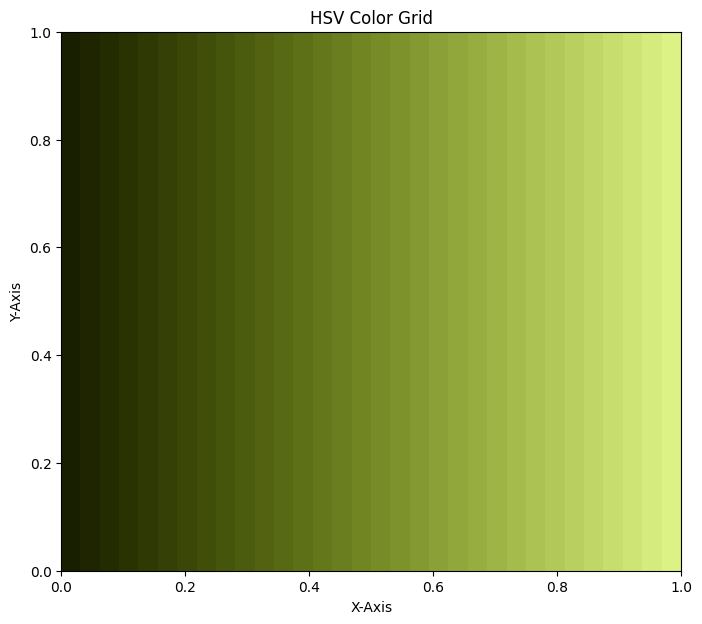

In [221]:
display_hsv_grid(hue, sats, vals)

In [222]:
import colorsys

def hsv_to_hex(h, s, v):
  """
  Converts HSV float values (each in range 0-1) to a hex color string.
  
  Args:
    h (float): Hue (0 to 1)
    s (float): Saturation (0 to 1)
    v (float): Value (0 to 1)
    
  Returns:
    str: A 6-digit hex color string (e.g., "#ff0000")
  """
  # 1. Convert HSV (0-1) to RGB (0-1)
  r, g, b = colorsys.hsv_to_rgb(h, s, v)
  
  # 2. Convert RGB (0-1) to RGB (0-255) integers
  r_int = int(r * 255)
  g_int = int(g * 255)
  b_int = int(b * 255)
  
  # 3. Format as hex string
  # :02x formats an integer as a 2-digit hexadecimal number
  return f'#{r_int:02x}{g_int:02x}{b_int:02x}'



sats = np.linspace(1,0.6, 32)
vals = np.linspace(0.2,0.99, 32)
warp_hues = np.linspace(1,0,32)

colors = []
for i in range(1024): 
  warp_id = i // 32 
  lane_id = i % 32 
  if (warp_id > 0):
    warp_hue = warp_hues[warp_id].item()
    thread_sat = 0.1
    thread_val = 0.1 
    colors.append(hsv_to_hex(warp_hue, thread_sat, thread_val))    
  else: 
    lane_hue = warp_hues[lane_id]
    lane_sat = 1
    lane_val = vals[lane_id]
    colors.append(hsv_to_hex(lane_hue, thread_sat, thread_val))
  

In [229]:
m = 2 
S = np.array([32,32])
D = np.array([1,32])
b_bits = 3
m_base = 1
s_shift = 6
warp_size = 32
smem_word_width = 32
element_vector_size = 1
element_type_width = 32
address_atom_width = 8 
n_banks = 32

L = LayoutVisualizer(m, S,D, b_bits, m_base, s_shift, warp_size,
           smem_word_width, element_vector_size, element_type_width,
           address_atom_width, n_banks, thread_colors = colors, grid_width = 32)

Generating thread colors...
Using provided custom thread colors.
Interpreting colors as hex strings.
Preparing data sources for all permutations...
Data preparation complete.


In [230]:
L.display()

In [227]:
m = 2 
S = np.array([32,32])
D = np.array([32,1])
b_bits = 3
m_base = 1
s_shift = 6
warp_size = 32
smem_word_width = 32
element_vector_size = 1
element_type_width = 32
address_atom_width = 8 
n_banks = 32

L = LayoutVisualizer(m, S,D, b_bits, m_base, s_shift, warp_size,
           smem_word_width, element_vector_size, element_type_width,
           address_atom_width, n_banks, thread_colors = colors, grid_width = 32)

Generating thread colors...
Using provided custom thread colors.
Interpreting colors as hex strings.
Preparing data sources for all permutations...
Data preparation complete.


In [228]:
L.display()